#  Прогнозирование заказов такси

Собраны исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

### Цель

Построить модель, которая будет прогнозировать количество заказов такси на следующий час, основываясь на исторических данных.

### Задачи

1. Загрузить, изучить и обработать данные.
2. Выполнить ресемплирование данных по одному часу.
3. Проанализировать данные.
4. Разделить данные на выборки.
5. Обучить модели с различными гиперпараметрами и выбрать лучшую.
6. Проверить данные на тестовой выборке и сделать вывод.


### Описание данных

В нашем распоряжении исторические данные о заказах такси в аэропортах.

## Подготовка

**Загрузим данные**

In [1]:
# Импортируем необходимые инструменты
import pandas as pd
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     TimeSeriesSplit, GridSearchCV)
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import (mean_squared_error, make_scorer)
from sklearn.linear_model import (LinearRegression, LogisticRegression)
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df = pd.read_csv('taxi.csv')
except: 
    df = pd.read_csv('/datasets/taxi.csv')

**Изучим данные**

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df.duplicated().sum()

0

Пропусков и явных дубликатов нет.

**Преобразуем данные**

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [7]:
df.set_index('datetime', inplace=True)

In [8]:
df.sort_index(inplace=True)

In [9]:
df.index.min()

Timestamp('2018-03-01 00:00:00')

In [10]:
df.index.max()

Timestamp('2018-08-31 23:50:00')

Имеем данные за 2018 г. с начала марта по конец августа

In [11]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [13]:
df.index.is_monotonic

True

Ряд последователен и непрерывен

## Анализ

**Выполним ресемплирование данных**

In [14]:
df = df.resample('1H').sum()

In [15]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Выполним декомпозицию ряда на тренд, циклические составляющие и случайный шум**

In [16]:
decomposed = seasonal_decompose(df)

<AxesSubplot: xlabel='datetime'>

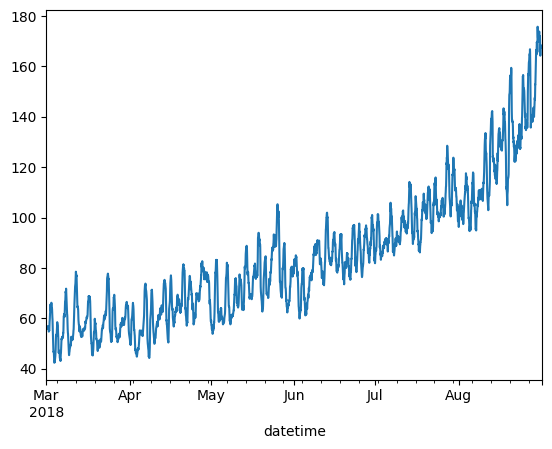

In [17]:
# тренд
decomposed.trend.plot()

Наблюдаем рост среднего значения ряда от марта к августу, это иожно объяснить естественным ростом продаж билетов в летние месяцы.

<AxesSubplot: xlabel='datetime'>

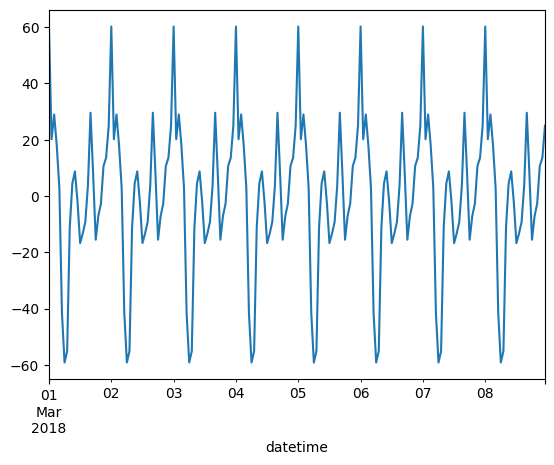

In [18]:
# сезонная компонента
decomposed.seasonal['2018-03-01':'2018-03-08'].plot()

Наблюдаем колебания периодом в одни сутки, что является естественным для заказов такси. В признаковое пространство необходимо добавить время (часы).

<AxesSubplot: xlabel='datetime'>

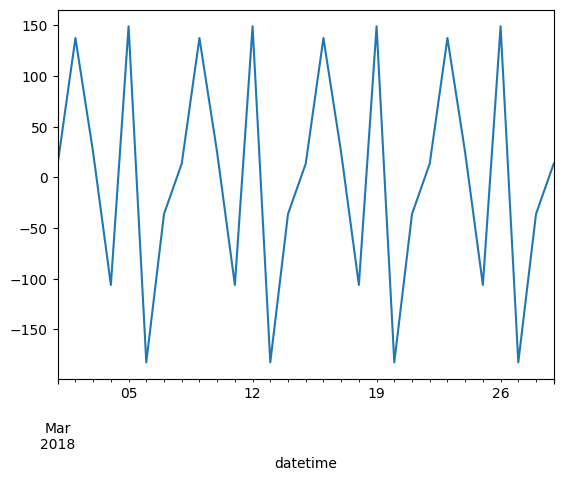

In [19]:
decomposed1 = seasonal_decompose(df.resample('1D').sum())
decomposed1.seasonal['2018-03-01':'2018-03-29'].plot()



Также наблюдаем сезонность относительно дней недели.

<AxesSubplot: xlabel='datetime'>

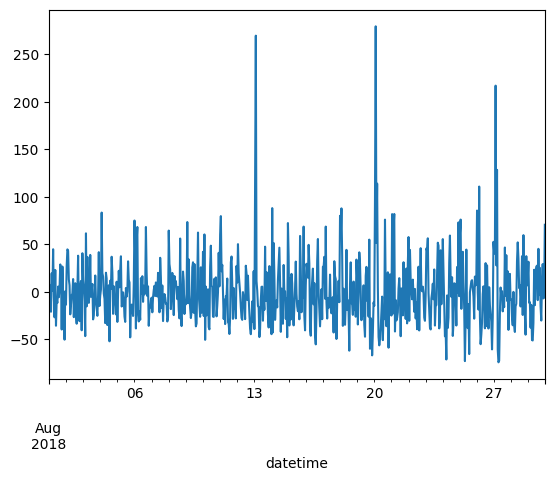

In [20]:
decomposed.resid['2018-08-01':'2018-08-29'].plot()

Функция для создания признаков. Будем использовать календарные признаки и "отстающие значения". Скользящее среднее будем считать за последние 24 часа, т.к. период колебаний спроса составляет одни сутки. Также будем учитывать этот факт при подборе величины отставания.

In [21]:
def make_features(data, min_lag, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['hour'] = new_data.index.hour # учет суточной сезонности
    new_data['dayofweek'] = new_data.index.dayofweek # учет недельной сезонности

    for lag in range(min_lag, max_lag + 1): # учет влияния "вчерашних" событий на "сегодняшние"
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].rolling(rolling_mean_size).mean().shift(1) # скользящее среднее как аналог тренда
    new_data.dropna(inplace=True)
    return new_data

In [22]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Добавим недостающие признаки**

С учетом выставленной сезонности (час и день недели) и для минимизации числа используемых факторов выберем запаздывание, равное 1.

In [23]:
df = make_features(df, 1, 1, 24)

In [24]:
# Здесь будут храниться rmse моделей
models = pd.DataFrame(columns=['model', 'RMSE'])

## Обучение

**Создадим scorer**

In [25]:
# Метрика качества
def rmse(y_true,y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [26]:
# Создадим scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

**Подготовим выборки для моделей**

In [27]:
train, test = train_test_split(
    df, test_size=0.1, random_state=12345, shuffle=False)

In [28]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

**LinearRegression**

In [29]:
# Создаем модель
linear_model = LinearRegression()

In [30]:
# Используем кросс-вадидацию
scores = cross_val_score(estimator=linear_model, X=features_train,
                         y=target_train, cv=TimeSeriesSplit(n_splits=8), # размер валидационной выборки примерно совпадает с размером тестовой выборки
                         scoring=rmse_scorer)


In [31]:
linear_model.fit(features_train, target_train)

LinearRegression()

In [32]:
# Резульат
scores.mean()

-31.34322751744601

In [33]:
models = models.append({'model':'LinearRegression', "RMSE":31.34}, 
                       ignore_index=True)

**LGBMRegressor**

In [34]:
# Создаем модель
lgb_booster = LGBMRegressor(random_state=12345)

In [35]:
# Используем кросс-вадидацию
GS_lgb = GridSearchCV(estimator=lgb_booster,
                  param_grid = {'num_leaves':[x for x in range(10, 40, 10)],
                                'learning_rate':[0.05, 0.1, 0.15, 0.2],
                                'n_estimators':[x for x in range(80, 120, 10)]},
                                scoring=rmse_scorer, 
                                cv=TimeSeriesSplit(n_splits=8))

In [36]:
GS_lgb.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2],
                         'n_estimators': [80, 90, 100, 110],
                         'num_leaves': [10, 20, 30]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [37]:
# лучший результат 
GS_lgb.best_score_

-24.51962168455094

In [38]:
# модель с наилучшими гиперпараметрами
lgb_best = GS_lgb.best_estimator_

In [39]:
models = models.append({'model':'LGBMRegressor', "RMSE":24.5}, 
                       ignore_index=True)

**CatBoostRegressor**

In [40]:
cat_booster = CatBoostRegressor(random_state=12345)

In [41]:
# Создаем GridSearchCV объект
GS_cat = GridSearchCV(estimator = cat_booster,
                  param_grid = {'learning_rate':[0.05, 0.1, 0.15, 0.2],
                                'n_estimators':[x for x in range(80, 120, 10)]},
                  scoring = rmse_scorer,
                  cv=TimeSeriesSplit(n_splits=8))

In [42]:
GS_cat.fit(features_train, target_train)

0:	learn: 28.5959810	total: 137ms	remaining: 10.8s
1:	learn: 27.9609750	total: 138ms	remaining: 5.39s
2:	learn: 27.4242329	total: 140ms	remaining: 3.59s
3:	learn: 26.9027024	total: 141ms	remaining: 2.68s
4:	learn: 26.4114334	total: 142ms	remaining: 2.13s
5:	learn: 25.8519805	total: 144ms	remaining: 1.77s
6:	learn: 25.3262929	total: 145ms	remaining: 1.51s
7:	learn: 24.9146424	total: 146ms	remaining: 1.31s
8:	learn: 24.4875461	total: 147ms	remaining: 1.16s
9:	learn: 24.1286488	total: 148ms	remaining: 1.04s
10:	learn: 23.7448947	total: 149ms	remaining: 936ms
11:	learn: 23.3590082	total: 150ms	remaining: 852ms
12:	learn: 23.0234043	total: 152ms	remaining: 781ms
13:	learn: 22.6860426	total: 153ms	remaining: 719ms
14:	learn: 22.4402808	total: 154ms	remaining: 667ms
15:	learn: 22.1160896	total: 156ms	remaining: 623ms
16:	learn: 21.8254678	total: 157ms	remaining: 582ms
17:	learn: 21.6558172	total: 158ms	remaining: 545ms
18:	learn: 21.4271196	total: 159ms	remaining: 512ms
19:	learn: 21.1841259	

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001EAD3EE62B0>,
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2],
                         'n_estimators': [80, 90, 100, 110]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [43]:
# лучший результат 
GS_cat.best_score_

-24.437726746716635

In [44]:
# модель с наилучшими гиперпараметрами
GS_cat_best = GS_cat.best_estimator_

In [45]:
models = models.append({'model':'CatBoostRegressor', 'RMSE':24.4}, 
                       ignore_index=True)

**RandomForestRegressor**

In [46]:
forest_model = RandomForestRegressor(random_state=12345)

In [47]:
GS_forest = GridSearchCV(estimator = forest_model,
                  param_grid = {'max_depth':[5],
                  'n_estimators':[10, 20, 30]},
                  scoring = rmse_scorer,
                  cv=TimeSeriesSplit(n_splits=8))

In [48]:
GS_forest.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [5], 'n_estimators': [10, 20, 30]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [49]:
# лучший результат 
GS_forest.best_score_

-27.478906610224676

In [50]:
# модель с наилучшими гиперпараметрами
GS_forest_best = GS_forest.best_estimator_

In [51]:
models = models.append({'model':'RandomForestRegressor', 'RMSE':27.5}, 
                       ignore_index=True)

**DecisionTreeRegressor**

In [52]:
tree_model = DecisionTreeRegressor(random_state=12345)

In [53]:
GS_tree = GridSearchCV(estimator = tree_model,
                  param_grid = {'max_depth':range(15),
                  'min_samples_leaf':[10, 20, 30]},
                  scoring = rmse_scorer,
                  cv=TimeSeriesSplit(n_splits=8))

In [54]:
GS_tree.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': range(0, 15),
                         'min_samples_leaf': [10, 20, 30]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [55]:
# лучший результат 
GS_tree.best_score_

-25.762219823529136

In [56]:
# модель с наилучшими гиперпараметрами
GS_tree_best = GS_tree.best_estimator_

In [57]:
models = models.append({'model':'DecisionTreeRegressor', 'RMSE':25.8}, 
                       ignore_index=True)

**Выбор модели**

In [58]:
models

,model,RMSE
0,LinearRegression,31.34
1,LGBMRegressor,24.50
2,CatBoostRegressor,24.40
3,RandomForestRegressor,27.50
4,DecisionTreeRegressor,25.80


Наилучший результат показала модель CatBoostRegressor. Протестируем ее.

## Тестирование

In [59]:
cat_test_predictions = GS_cat_best.predict(features_test)

In [60]:
rmse(target_test, cat_test_predictions)

43.41141216413742

Добились значения rmse, равного 43.4, что ниже максимально допустимого 48. 

Визуально оценим качество предсказания

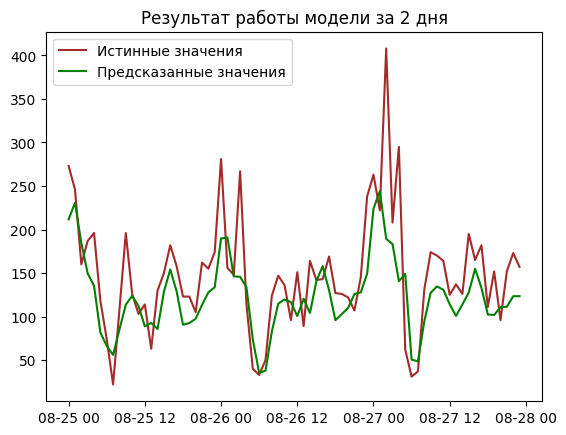

In [61]:
fig, ax = plt.subplots()
ax.plot(target_test['2018-08-25':'2018-08-27'], c = 'brown', label='Истинные значения')
ax.plot(pd.Series(data=cat_test_predictions, index=features_test.index)['2018-08-25':'2018-08-27'],
        c = 'green', label='Предсказанные значения')
ax.set_title('Результат работы модели за 2 дня')
ax.legend();

Видим, что результаты модели представляют собой более стационарный ряд по сравнению с истинным.

**Сравним модель с константной**

In [62]:
dummy_regr = DummyRegressor(strategy="median")

In [63]:
dummy_regr.fit(features_train, target_train)

DummyRegressor(strategy='median')

In [64]:
dummy_predictions = dummy_regr.predict(features_test)

In [65]:
rmse(target_test, dummy_predictions)

87.21093811714634

Модель прошла проверку на адекватность

## Вывод

Целью данного проекта было создание модели, предсказывающей число заказов такси на следующий час, основываясь на исторических данных. На тестовой выборке требовалось получить значение RMSE, меньшее 48.

В процессе анализа данных были обнаружены цикличность с периодом в 24 часа, тренд к росту среднего числа заказов от марта к августу, зависимость величины шума от дня недели. 

В признаковое пространство были добавлены календарыне признаки и 'отстающие значения'.

В ходе исследования были рассмотрены 5 моделей:
* LinearRegression;
* LGBMRegressor;
* CatBoostRegressor;
* RandomForestRegressor;
* DecisionTreeRegressor.

С учетом подбора гиперпараметров наилучший результат по качеству предсказания показала модель градиентного бустинга CatBoostRegressor, которая и была выбрана в качестве основной.

На тестовой выборке для модели CatBoostRegressor значение rmse равно 43.4, что удовлетворяет требованиям задания.
